### 1. Import Dependencies and Data

In [42]:
import tensorflow as tf
import tensorflow_datasets as tfds # for bringing in fashion mnist datasets
from matplotlib import pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [43]:
ds = tfds.load('fashion_mnist', split='train') # use the tensorflow datasets api to bring in datasource

In [44]:
type(ds)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [45]:
ds.as_numpy_iterator().next().keys()

dict_keys(['image', 'label'])

### 2. Vizualize Data and Build Dataset

In [46]:
import numpy as np # for data transformation

dataiterator = ds.as_numpy_iterator()  # setup connection aka iterator

In [47]:
dataiterator.next() # Getting data out of the pipeline

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

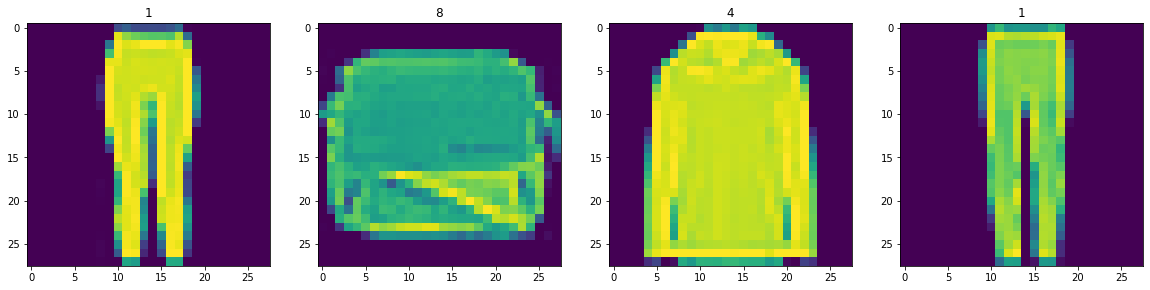

In [48]:
fig, ax  = plt.subplots(ncols=4, figsize=(20,20)) # setup the subplot formatting
for idx in range(4): # loop four times and get images
    sample = dataiterator.next() # grab an image and label
    ax[idx].imshow(np.squeeze(sample['image'])) # plot the image using a specific subplot
    ax[idx].title.set_text(sample['label']) # appending the image label as the plot title

In [49]:
def scale_images(data): # scale and return images only
    image = data['image']
    return image / 255

In [50]:
ds = ds.map(scale_images) # running the dataset through the scale_images preprocessing step
ds = ds.cache() # cache the dataset for that batch
ds = ds.shuffle(60000) # shuffle it up
ds = ds.batch(128) # batch into 128 images per sample
ds = ds.prefetch(64) # reduces the likelihood of bottlenecking

In [51]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

### 3. Build Neural Network

#### 3.1 Import Modelling Components

In [52]:
from tensorflow.keras.models import Sequential # bring in the sequential api for the generator and discriminator
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D # layers for the neural network

#### 3.2 Build Generator

In [53]:
def build_generator():
    model = Sequential()
    # takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    # Upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    # upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    # Conv Layer to get one channel
    model.add(Conv2D(1,4,padding='same', activation='sigmoid'))
    return model

In [54]:
generator = build_generator()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

In [55]:
img = generator.predict(np.random.randn(4, 128, 1))

1/1 [==============================] - 0s 81ms/step


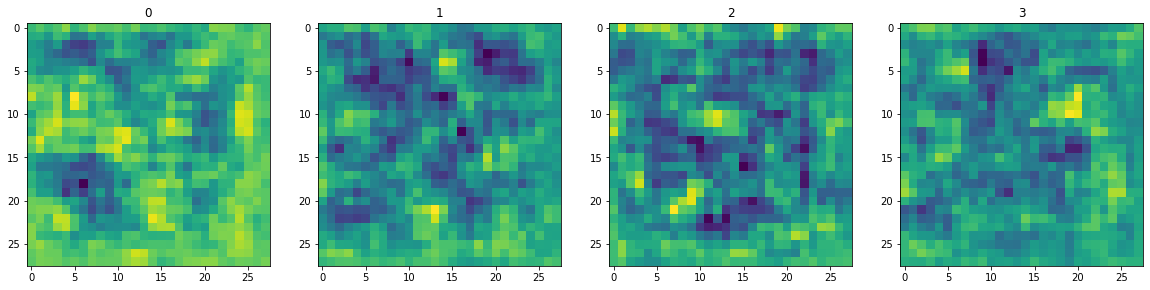

In [56]:
fig, ax  = plt.subplots(ncols=4, figsize=(20,20)) # setup the subplot formatting
for idx, img in enumerate(img): # loop four times and get images
    ax[idx].imshow(np.squeeze(img)) # plot the image using a specific subplot
    ax[idx].title.set_text(idx) # appending the image label as the plot title

#### 3.3 Build Discriminator

In [57]:
def build_discriminator():
    model = Sequential()
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape=(28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [58]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 128)      

In [59]:
img = generator.predict(np.random.randn(4, 128, 1))

1/1 [==============================] - 0s 15ms/step


In [60]:
discriminator.predict(img)

1/1 [==============================] - 0s 73ms/step


array([[0.5030221 ],
       [0.50308615],
       [0.50308615],
       [0.5030506 ]], dtype=float32)

### 4. Construct Training Loop

#### 4.1 Setup Losses and Optimizers

In [61]:
# Adam is going to be the optimizers for both
from tensorflow.keras.optimizers import Adam
# Binary Cross Entropy is going to be the loss for both
from tensorflow.keras.losses import BinaryCrossentropy

In [62]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

#### 4.2 Build Subclassed Model

In [63]:
from tensorflow.keras.models import Model # importing the base model class to subclass our training step

In [64]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)
        # Create atrributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class 
        super().compile(*args, **kwargs)
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        real_images = batch # Get the data
        fake_images = self.generator(tf.random.normal((128,128,1)), training=False)
        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images through the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            # Create labels for real and fake images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0) 
            # Calculate Loss - BinaryCrossEntropy
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
        # Apply backpropagation -nn Learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # Apply the backprop    
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        return {"d_loss": total_d_loss, "g_loss": total_g_loss}

In [65]:
# Create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

In [66]:
# Compiling the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

#### 4.3 Build Callback

In [67]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [68]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('/content/drive/MyDrive/Data Science WorkSpace/Deep Learning Projects/Fashion GAN Project', 'images', f'generated_img_{epoch}_{i}.png'))

#### 4.3 Train

In [69]:
# Recommended epochs = 2000
hist = fashgan.fit(ds, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20
  6/469 [..............................] - ETA: 1:03 - d_loss: 0.6915 - g_loss: 0.6948

469/469 [==============================] - 68s 142ms/step - d_loss: 0.5570 - g_loss: 0.9631
Epoch 2/20
469/469 [==============================] - 69s 147ms/step - d_loss: 0.7061 - g_loss: 0.7090
Epoch 3/20
469/469 [==============================] - 69s 147ms/step - d_loss: 0.6952 - g_loss: 0.7019
Epoch 4/20
469/469 [==============================] - 69s 147ms/step - d_loss: 0.6948 - g_loss: 0.6860
Epoch 5/20
469/469 [==============================] - 69s 147ms/step - d_loss: 0.6892 - g_loss: 0.7120
Epoch 6/20
469/469 [==============================] - 69s 146ms/step - d_loss: 0.6965 - g_loss: 0.6591
Epoch 7/20
469/469 [==============================] - 69s 147ms/step - d_loss: 0.3669 - g_loss: 2.2095
Epoch 8/20
469/469 [==============================] - 69s 146ms/step - d_loss: 0.2736 - g_loss: 2.7196
Epoch 9/20
469/469 [==============================] - 68s 146ms/step - d_loss: 0.2710 - g_loss: 2.7347
Epoch 10/20
469/469 [==============================] - 68s 146ms/step - d_loss: 0.26

#### 4.4 Review Performance

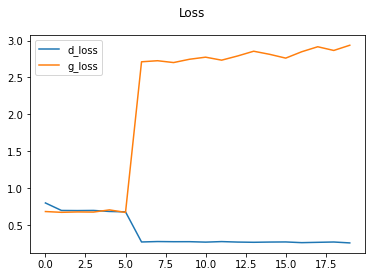

In [70]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

### 5. Test Out the Generator

#### 5.1 Generate Images

In [71]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))
imgs.shape

1/1 [==============================] - 0s 16ms/step


(16, 28, 28, 1)

TypeError: ignored

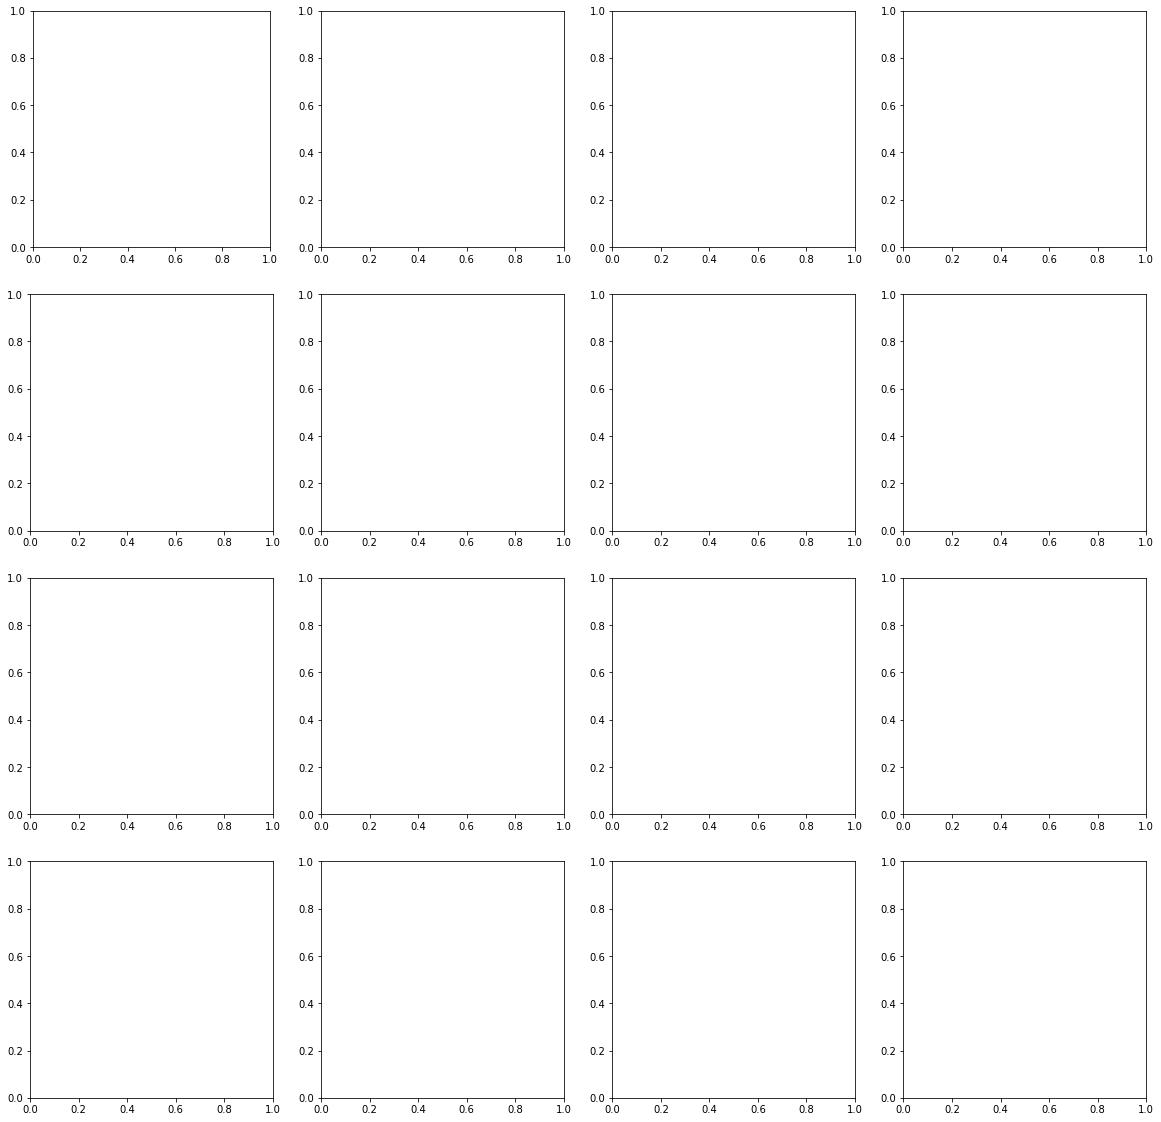

In [72]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(20,20))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

#### 5.2 Save the model

In [73]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')